### Single round of instructor training for hold task (for exploratory purposes)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from disp import set_plot, colors

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 1.12.1
Cuda available: False
Device: cpu


In [2]:
torch.manual_seed(1337)

# model params
D = 2
N = 2000
TAU = .01
G = 100
DT = .001

J_psi = G*torch.randn((N, D), device=device)
B = torch.eye(D, device=device)
C = torch.eye(D, device=device)

def get_z(x):
    return 1*x

def psi_fn(z):
    return (1+torch.tanh(J_psi@z))*np.sqrt(2/N)

def eval_F(x, w_T, u):
    z = get_z(x)
    psi = psi_fn(z).reshape((N, 1))
    return (1/TAU)*(-x + C@w_T@psi + B@u)
    
def advance(x, z, w_T, u, L_nz, ml):
    x_next = x+DT*eval_F(x, w_T, u)
    z_next = get_z(x_next)
    psi_next = psi_fn(z_next)
    
    L = L_nz*ml
    w_T_next = w_T + DT*L@psi_next.T
    return x_next, w_T_next

## Demo of long-range memory using learning rule

In [3]:
# smln params
T = 1.

LR = 10000
NEPOCH = 50

# loss eval
DELAY = .46

# initial conditions
x_0 = torch.tensor([[1., 1.]], device=device).T
w_T_hat_0 = torch.zeros((D, N), device=device)

# inputs
T_U_STIMS = [.001, .501]

# non-zero instructive signals
T_L_NZS = [T_U_STIM+0 for T_U_STIM in T_U_STIMS]

In [4]:
# get integer time idxs
IT = int(round(T/DT))
IT_U_STIMS = [int(round(T_U/DT)) for T_U in T_U_STIMS]
IT_L_NZS = [int(round(T_L_NZ/DT)) for T_L_NZ in T_L_NZS]
T_LOSSS = [T_U_STIM + DELAY for T_U_STIM in T_U_STIMS]
IT_LOSSS = [int(round(T_LOSS/DT)) for T_LOSS in T_LOSSS]

# make inputs
us = torch.zeros((IT, D), device=device)
us[:, 1] = 1.
us[IT_U_STIMS[0], 0] = -.02/DT
us[IT_U_STIMS[1], 0] = .02/DT

# mask for nonzero learning signals
ML = torch.zeros((IT, D), device=device)
ML[IT_L_NZS, 0] = 1

In [5]:
# specify loss
MLOSS = torch.zeros((IT, D), device=device)  # mask for loss
MLOSS[IT_LOSSS, 0] = 1

TARGS = torch.zeros((IT, D), device=device)
TARGS[MLOSS > 0] = torch.tensor([-1., 1.], device=device)

def loss_fn(zs):
    return torch.mean(((zs - TARGS)**2)[MLOSS>0])

Demo round

In [6]:
L_nz = ML.clone().detach()*0  # initialize instructor signal
L_nz.requires_grad = True

losses = []
L_nz_save = []
z_hats_save = []

for epoch in range(NEPOCH):

    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]
    w_T_hats = [w_T_hat_0.clone()]

    for ct in range(1, IT):
        x_hat_next, w_T_hat_next = advance(x_hats[-1], z_hats[-1], w_T_hats[-1], us[[ct], :].T, L_nz[[ct], :].T, ML[[ct], :].T)
        z_hat_next = get_z(x_hat_next)

        x_hats.append(x_hat_next)
        z_hats.append(z_hat_next)
        w_T_hats.append(w_T_hat_next)

    x_hats_cc = torch.cat(x_hats, dim=1).T
    z_hats_cc = torch.cat(z_hats, dim=1).T
    w_T_hats_stack = torch.stack(w_T_hats)

    loss = loss_fn(z_hats_cc)
    loss.backward()

    with torch.no_grad():
        L_nz -= LR*L_nz.grad
        L_nz.grad.zero_()

    losses.append(loss.item())

    if epoch == 0 or ((epoch + 1)%50 == 0) or (epoch+1 == NEPOCH):
        z_hats_save.append(z_hats_cc.clone().detach().numpy())
        L_nz_save.append(L_nz.clone().detach().numpy())

w_T_hat_0 = w_T_hats[-1].detach()

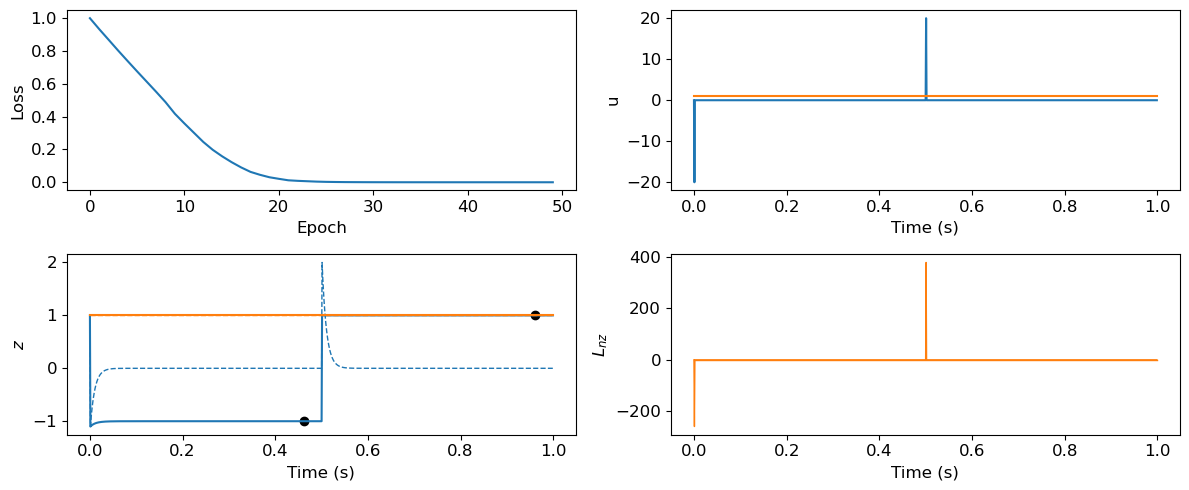

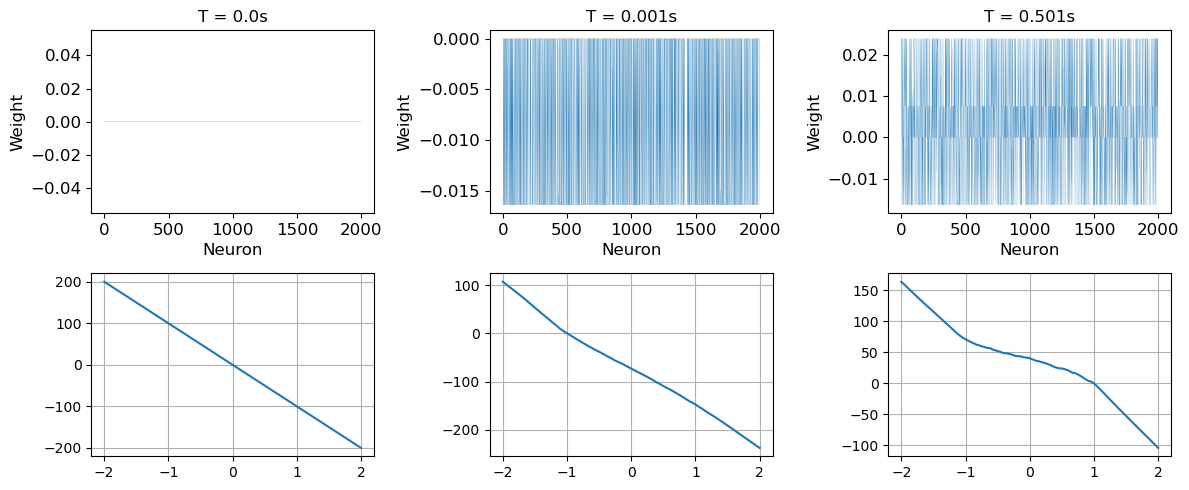

In [7]:
# plotting params
t = np.arange(IT)*DT
RX = np.linspace(-2, 2, 100)
T_W_PLOTS = [0.] + [T_U_STIM for T_U_STIM in T_U_STIMS]
IT_W_PLOTS = [int(round(T_W_PLOT/DT)) for T_W_PLOT in T_W_PLOTS]

fig, axs = plt.subplots(2, 2, figsize=(12, 5), tight_layout=True)
axs = axs.flatten()

axs[0].plot(range(NEPOCH), losses)
set_plot(axs[0], x_label='Epoch', y_label='Loss')

axs[1].plot(t, us)
set_plot(axs[1], x_label='Time (s)', y_label='u')

for d, c in zip(range(D), colors):
    axs[2].plot(t, z_hats_save[0][:, d], c=c, lw=1, ls='--')
    axs[2].plot(t, z_hats_save[-1][:, d], c=c)
    
for itmloss, cmloss in torch.nonzero(MLOSS):
    axs[2].scatter(itmloss*DT, TARGS[itmloss, cmloss], c='k')
    
set_plot(axs[2], x_label='Time (s)', y_label='$z$')

axs[3].plot(t, L_nz.detach(), c=c, lw=1)
set_plot(axs[3], x_label='Time (s)', y_label=r'$L_{nz}$')

# plot weights and flow fields
fig, axs = plt.subplots(2, 3, figsize=(12, 5), tight_layout=True)
axs = axs.flatten()

# weights
for T_W_PLOT, IT_W_PLOT, ax in zip(T_W_PLOTS, IT_W_PLOTS, axs[:3]):
    w_T_hat_temp = w_T_hats[IT_W_PLOT].detach().numpy()
    ax.plot(w_T_hat_temp.T, lw=.1)
    set_plot(ax, x_label='Neuron', y_label='Weight', title=f'T = {T_W_PLOT}s')

# flow fields
for T_W_PLOT, IT_W_PLOT, ax in zip(T_W_PLOTS, IT_W_PLOTS, axs[3:]):
    w_T_hat_temp = w_T_hats[IT_W_PLOT].detach().numpy()
    F_temp = torch.stack([eval_F(torch.tensor([[x_, 1.]], dtype=torch.float).T, w_T_hat_temp, torch.tensor([[0, 1.]]).T)[0] for x_ in RX])
    ax.plot(RX, F_temp)
    ax.grid()